
Reinforcement Learning (DQN) Tutorial
=====================================

This [tutorial](http://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) shows how to use Tensorflow 2.0 to train a Deep Q Learning (DQN) agent
on the CartPole-v0 environment from the [OpenAI Gym](https://gym.openai.com/).

**CartPole Task**

The agent has to decide between two actions - moving the cart left or
right - so that the pole attached to it stays upright. You can find an
official leaderboard with various algorithms and visualizations at the
[Gym website](https://gym.openai.com/envs/CartPole-v0).

As the agent observes the current state of the environment and chooses
an action, the environment *transitions* to a new state, and also
returns a reward that indicates the consequences of the action. In this
task, the environment terminates if the pole falls over too far.

<img src="https://github.com/pytorch/tutorials/raw/master/_static/img/cartpole.gif">

The CartPole task is designed so that the inputs to the agent are 4 real
values representing the environment state (position, velocity, etc.).
However, neural networks can solve the task purely by looking at the
scene, so we'll use a patch of the screen centered on the cart as an
input. Because of this, our results aren't directly comparable to the
ones from the official leaderboard - our task is much harder.
Unfortunately this does slow down the training, because we have to
render all the frames.

Strictly speaking, we will present the state as the difference between
the current screen patch and the previous one. This will allow the agent
to take the velocity of the pole into account from one image.

**Packages**


First, let's import needed packages. Firstly, we need [`gym`](https://gym.openai.com/docs) for the environment. We'll also use the following from PyTorch:

-  neural networks (``tensorflow.nn``)
-  optimization (``tensorflow.keras.optimizers``)
-  automatic differentiation (``tensorflow.GradientTape``)
-  tilities for vision tasks (``tensorflow.image``)

# Reference Papers
- [Mnih, Volodymyr, et al. "Playing atari with deep reinforcement learning." arXiv preprint arXiv:1312.5602 (2013)](https://arxiv.org/abs/1312.5602).

In [1]:
import os
import random
import sys
import tempfile
import warnings
from collections import namedtuple
from itertools import count
from typing import Any, Callable, List, Tuple

import gym
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from matplotlib import pyplot
from tensorflow.keras import activations, layers, losses, optimizers
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.keras.losses import huber_loss
from IPython import get_ipython

In [2]:
# this script's parent directory
script_dir = os.path.sep.join(os.path.sep.split(sys.argv[0])[:-1])

In [3]:
# magic seed, hahaha
random.seed(12)
np.random.seed(12)
tf.random.set_seed(12)

In [4]:
test_env = gym.envs.make("CartPole-v0").unwrapped
test_env.reset()

[2020-03-06 02:07:32,667] Making new env: CartPole-v0
/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


array([-0.01262825, -0.04854411,  0.01733436,  0.01011364])

## Setting Up CPU/GPU

In [5]:
# check available devices
physical_devices = tf.config.experimental.list_physical_devices()
print(*physical_devices, sep="\n")

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [6]:
# using GPU
DEVICE_ID = "GPU:0"

Replay Memory
-------------

We'll be using a buffer of experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we're going to need two classses:

-  ``Transition`` - a named tuple representing a single transition in
   our environment
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.


In [7]:
Transition = namedtuple(
    "Transition", ("state", "action", "reward", "next_state"))
# Observation = namedtuple("Observation", ("position", "velocity", "pole_angle", "tip_velocity"))

In [8]:
class ReplayMemory:

    def __init__(self, capacity: int):
        self.capacity: int = capacity
        self.position = 0
        self.memory: List[Any] = []

    def __len__(self) -> int:
        return len(self.memory)

    def push(self, *transition: Any) -> None:
        """
        push state transition ```transition``` into replay memory and clip to storage capacity
        the gc frees the memory hopefully, lol.
        """
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, sample_size: int) -> List[Any]:
        """
        randomly sample ```sample_size``` state transitions from the replay memory
        """
        return random.sample(self.memory, sample_size)

In [9]:
test_mem = ReplayMemory(10)

for i in range(16):
    test_mem.push(i, i)

test_sample = test_mem.sample(10)
print(test_sample)

set(test_sample) == set((i, i) for i in range(6, 16))

[(7, 7), (14, 14), (15, 15), (11, 11), (13, 13), (10, 10), (12, 12), (6, 6), (9, 9), (8, 8)]


True

Now, let's define our model. But first, let quickly recap what a DQN is.

DQN algorithm
-------------

Our environment is deterministic, so all equations presented here are
also formulated deterministically for the sake of simplicity. In the
reinforcement learning literature, they would also contain expectations
over stochastic transitions in the environment.

Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where
$R_{t_0}$ is also known as the *return*. The discount,
$\gamma$, should be a constant between $0$ and $1$
that ensures the sum converges. It makes rewards from the uncertain far
future less important for our agent than the ones in the near future
that it can be fairly confident about.

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

However, we don't know everything about the world, so we don't have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

To minimise this error, we will use the [Huber
loss](https://en.wikipedia.org/wiki/Huber_loss). The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}

### Q-network

Our model will be a convolutional neural network that takes in the
difference between the current and previous screen patches. It has two
outputs, representing $Q(s, \mathrm{left})$ and
$Q(s, \mathrm{right})$ (where $s$ is the input to the
network). In effect, the network is trying to predict the *quality* of
taking each action given the current input.

In [10]:
ACTION_SPACE_SIZE = 2

In [11]:
class DQN(tf.keras.Model):

    def __init__(self, action_space_size: int):
        super().__init__()
        self.conv_1 = layers.Conv2D(16, kernel_size=(
            5, 5), strides=(2, 2), activation=activations.relu)
        self.bnorm_1 = layers.BatchNormalization()
        self.conv_2 = layers.Conv2D(32, kernel_size=(
            5, 5), strides=(2, 2), activation=activations.relu)
        self.bnorm_2 = layers.BatchNormalization()
        self.conv_3 = layers.Conv2D(32, kernel_size=(
            5, 5), strides=(2, 2), activation=activations.relu)
        self.bnorm_3 = layers.BatchNormalization()
        self.flatten = layers.Flatten()
        self.low_rank = layers.Dense(units=action_space_size)

    def call(self, batch: EagerTensor) -> EagerTensor:
        x = self.conv_1(batch)
        x = self.bnorm_1(x)
        x = self.conv_2(x)
        x = self.bnorm_2(x)
        x = self.conv_3(x)
        x = self.bnorm_3(x)
        x = self.flatten(x)
        x = self.low_rank(x)

        return x

In [12]:
for device in physical_devices:
    if device.device_type == "GPU":
        tf.config.experimental.set_memory_growth(device, True)

In [13]:
# test if model is ok and has no layout errors
# we are not actually using the Huber loss directly, this is just for testing here
test_nn = DQN(ACTION_SPACE_SIZE)

test_nn.compile(optimizer=optimizers.RMSprop(), loss=keras.losses.Huber())

In [14]:
# test training
with tf.device(DEVICE_ID):
    test_nn.fit(tf.zeros((12, 40, 80, 3)), tf.zeros((12,)), epochs=2)

Train on 12 samples
Epoch 1/2
12/12 [==============================] - 2s 159ms/sample - loss: 0.0000e+00
Epoch 2/2
12/12 [==============================] - 0s 700us/sample - loss: 0.0000e+00


In [15]:
test_nn.summary()

Model: "dqn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1216      
_________________________________________________________________
batch_normalization (BatchNo multiple                  64        
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  12832     
_________________________________________________________________
batch_normalization_1 (Batch multiple                  128       
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  25632     
_________________________________________________________________
batch_normalization_2 (Batch multiple                  128       
_________________________________________________________________
flatten (Flatten)            multiple                  0       

## Important Terms
- ```world_height``` and ```world_width```:
- ```screen_height``` and ```screen_width```:
- ```view_width``` and ```view_height```:

*Pre-configured to the gym cartpole env*

In [16]:
# deterministic configurations from OpenAI Gym's CartPoleV1 environment
SCREEN_WIDTH: int = 600
SCREEN_HEIGHT: int = 400

*Our View Configurations*

In [17]:
# width and height of our desired view/part of the screen
VIEW_HEIGHT: int = 160
VIEW_WIDTH: int = 320
DOWNSCALE_FACTOR: float = 0.25

In [18]:

INPUT_HEIGHT = int(DOWNSCALE_FACTOR * VIEW_HEIGHT)
INPUT_WIDTH = int(DOWNSCALE_FACTOR * VIEW_WIDTH)

print("H X W:", (INPUT_HEIGHT, INPUT_WIDTH))

H X W: (40, 80)


### Input extraction

The code below are utilities for extracting and processing rendered
images from the environment. It uses the ``tensorflow.image`` module, which
makes it easy to compose image transforms as tensorflow native functions. Once you run the cell it will
display an example patch that it extracted.


In [19]:
# hard coded to our use case
@tf.function
def resize_image_to_input(images: tf.Tensor) -> tf.Tensor:
    return tf.image.resize(images, method="bilinear", size=(INPUT_HEIGHT, INPUT_WIDTH))

In [20]:
def get_world_parameters(env: gym.Env, screen_width: int) -> Tuple[float, float]:
    """
    get the world's width and the linear scale required to
    project it to the desired screen width
    """
    # -2.4, 2.4 => 0, 2.4 * 2
    # [-world_width/2, world_width/2] => [0, world_width]
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return world_width, scale

In [21]:
def get_cart_location(env: gym.Env, screen_width: int) -> int:
    """
    get cart's horizontal location relative to the screen width
    """
    _, scale = get_world_parameters(env, screen_width)
    
    # since state position observations are relative to the world,
    # convert to screen coordinates
    
    # scale from [-world_width/2, world_width/2] to  [-screen_pos/2,screen_pos/2]
    screen_pos = env.state[0] * scale
    
    # convert from [-screen_pos/2, screen_pos/2] to [0, screen_pos]
    screen_pos = screen_pos + screen_width / 2
    
    return int(screen_pos)

In [22]:
def trailing_window_slice(screen: np.ndarray, location: int, window_size: int) -> np.ndarray:
    
    # trimming along the vertical axis, dependent on cart's location
    
    # sliding trailing window that trims/slices along the vertical axis.
    # stops sliding when the slidig window touches any of the edges
    # window trails ```location``` such that ```location``` is always in the window's midpoint
    # until the window touches the screen edges
    
    # center of cart is towards the left edge
    if location < window_size // 2:
        screen = screen[:, :window_size, :]
    # center of cart is towards the right edge
    elif location > (screen.shape[1] - window_size // 2):
        screen = screen[:, :-window_size, :]
    else:
        # crop at position that is neither at the right nor left edge
        beg_index = (location - window_size // 2)
        end_index = (location + window_size // 2)
        
        screen = screen[:, beg_index:end_index, :]
    
    return screen

In [23]:
def preprocess_screen(env: gym.Env, screen: np.ndarray) -> EagerTensor:
    # hard-coded to our use case
    # screen: np.ndarray of dtype np.float
    # trimming along the horizontal axis
    # remove upper part of the screen, pole never reaches that height, nor any of the world observation
    upper_trim:int = 160
    lower_trim:int = upper_trim + VIEW_HEIGHT
    screen = screen[upper_trim:lower_trim, :, :]
    
    cart_location = get_cart_location(env, SCREEN_WIDTH)
    
    screen = trailing_window_slice(screen, cart_location, VIEW_WIDTH)
    
    screen = resize_image_to_input(screen)
    
    # screen = tf.clip_by_value(screen, clip_value_min=0.0, clip_value_max=1.0)
    
    return screen

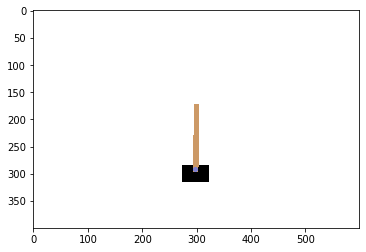

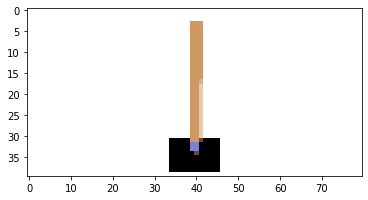

In [24]:
test_img = test_env.render(mode="rgb_array") / 255.0
pyplot.imshow(test_img)
pyplot.show()
pyplot.imshow(preprocess_screen(test_env, test_img))
pyplot.show()

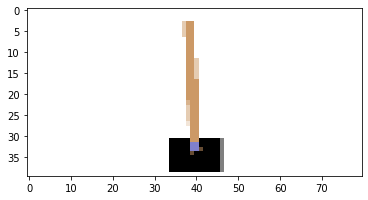

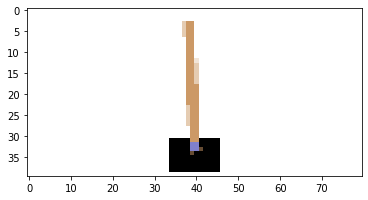

[2020-03-06 02:07:38,214] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


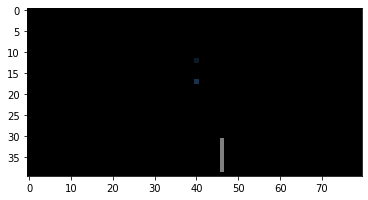

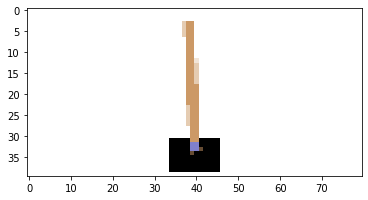

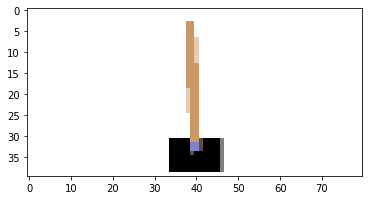

[2020-03-06 02:07:38,584] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


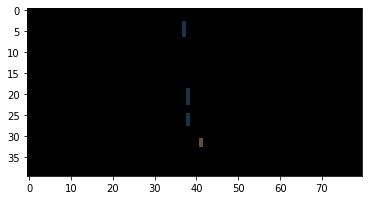

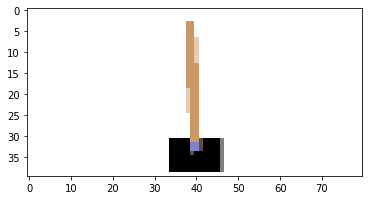

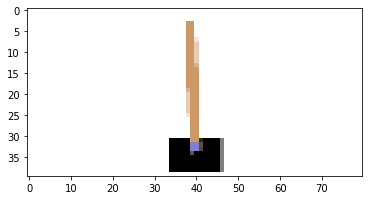

[2020-03-06 02:07:38,964] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


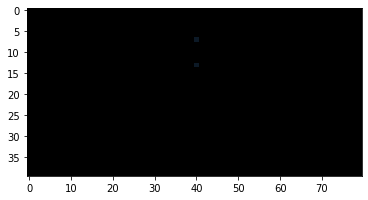

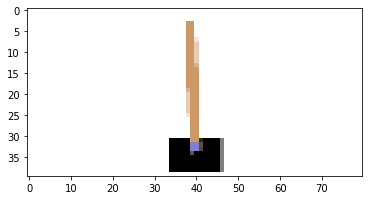

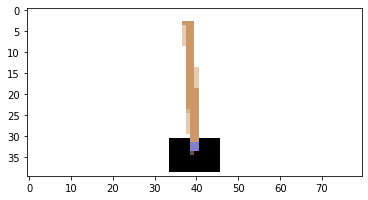

[2020-03-06 02:07:39,361] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


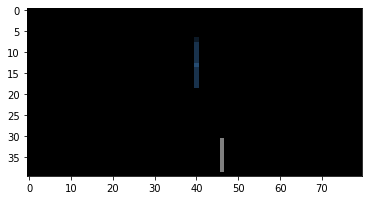

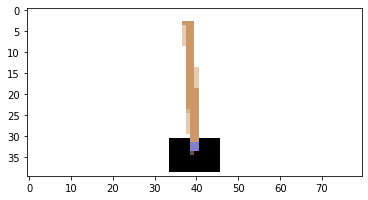

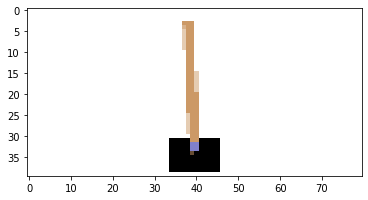

[2020-03-06 02:07:39,737] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


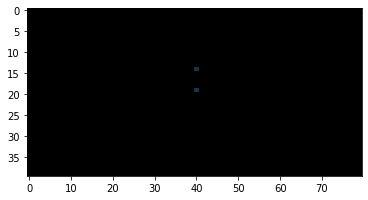

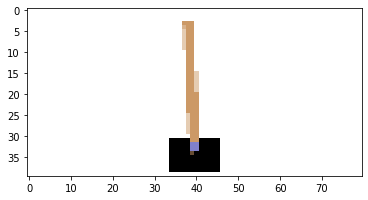

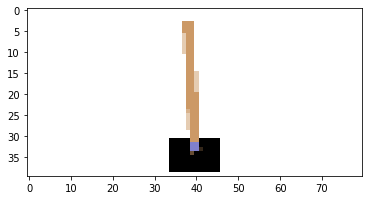

[2020-03-06 02:07:40,099] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


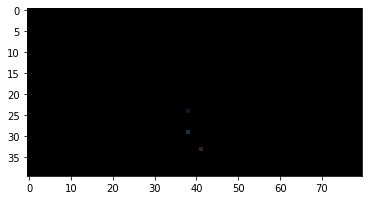

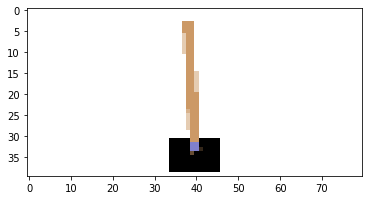

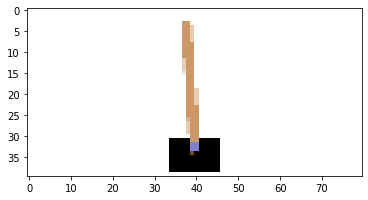

[2020-03-06 02:07:40,490] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


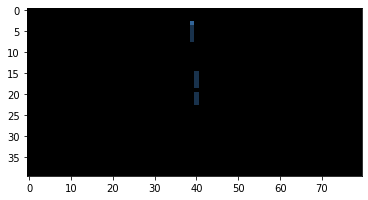

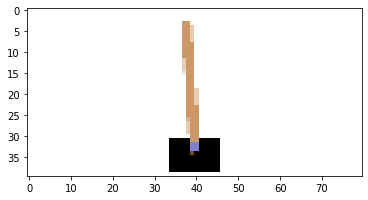

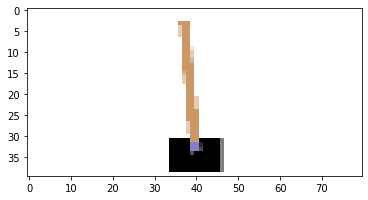

[2020-03-06 02:07:40,879] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


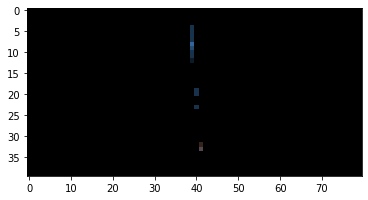

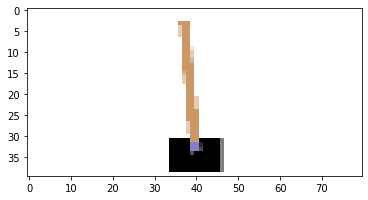

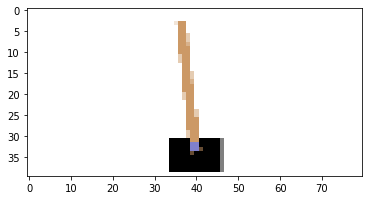

[2020-03-06 02:07:41,355] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


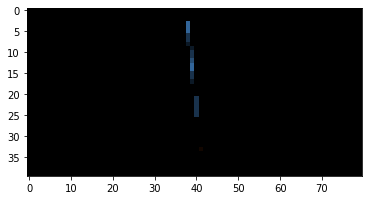

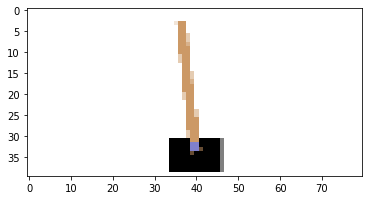

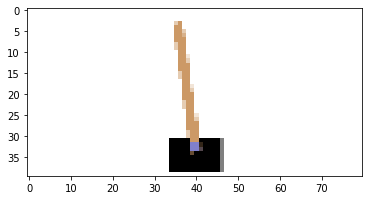

[2020-03-06 02:07:41,728] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


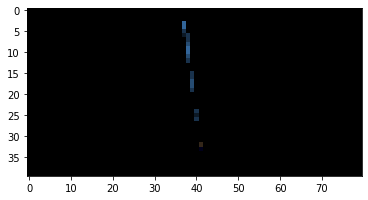

In [25]:
test_env.reset()
for i in range(10):
    test_prev_screen = preprocess_screen(test_env, test_env.render(mode="rgb_array") / 255.0)

    test_action = test_env.action_space.sample()

    *_, done,_ = test_env.step(test_action)
    test_next_screen = preprocess_screen(test_env, test_env.render(mode="rgb_array") / 255.0)

    pyplot.imshow(test_prev_screen)
    pyplot.show()
    pyplot.imshow(test_next_screen)
    pyplot.show()
    #x = preprocess_screen(test_env,test_prev_screen)
    #y = preprocess_screen(test_env,test_next_screen)
    #z = tf.concat([x, y], axis=0)
    test_state = test_next_screen - test_prev_screen
    pyplot.imshow(test_state)
    pyplot.show()
    
    if done:
        test_env.reset()

# Description:
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.

## Source:
This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson
        
## Observation: 
Type: Box(4)

<table>
    <tr><td><b>  Num   </b></td><td><b>  Observation </b></td><td><b>  Min </b></td><td><b> Max </b></td></tr>
<tr><td>     0  </td><td>  Cart Position  </td><td>  -4.8  </td><td>  4.8 </td></tr>
<tr><td>     1  </td><td>  Cart Velocity </td><td>    -Inf </td><td>    Inf </td></tr>
<tr><td>     2  </td><td>  Pole Angle </td><td>    -24 deg </td><td>    24 deg </td></tr>
<tr><td>     3  </td><td>  Pole Velocity At Tip </td><td>    -Inf </td><td>    Inf </td></tr>
</table>


## Actions:
Type: Discrete(2)
<table>
    <tr><td><b> Num </b></td><td><b>	Action </b></td></tr>
<tr><td>0	</td><td>Push cart to the left </td></tr>
<tr><td>1	</td><td>Push cart to the right </td></tr>
</table>
        
Note: The amount the velocity that is reduced or increased is not fixed; it depends on the angle the pole is pointing. This is because the center of gravity of the pole increases the amount of energy needed to move the cart underneath it

## Reward:
Reward is 1 for every step taken, including the termination step


## Starting State:
All observations are assigned a uniform random value in [-0.05..0.05]

## Episode Termination:
- Pole Angle is more than 12 degrees
- Cart Position is more than 2.4 (center of the cart reaches the edge of the display)
- Episode length is greater than 200

## Solved Requirements
- Considered solved when the average reward is greater than or equal to 195.0 over 100 consecutive trials.

Training
--------

### Hyperparameters and utilities

This cell instantiates our model and its optimizer, and defines some
utilities:

-  ``Variable`` - this is a simple wrapper around
   ``torch.autograd.Variable`` that will automatically send the data to
   the GPU every time we construct a Variable.
-  ``select_action`` - will select an action accordingly to an epsilon
   greedy policy. Simply put, we'll sometimes use our model for choosing
   the action, and sometimes we'll just sample one uniformly. The
   probability of choosing a random action will start at ``EPS_START``
   and will decay exponentially towards ``EPS_END``. ``EPS_DECAY``
   controls the rate of the decay.
-  ``plot_durations`` - a helper for plotting the durations of episodes,
   along with an average over the last 100 episodes (the measure used in
   the official evaluations). The plot will be underneath the cell
   containing the main training loop, and will update after every
   episode.




Computes:

\begin{align}y_{j} =  
\begin{cases} r_{j} & \text{if } s_{j+1 }  \text{ is terminal (final)}  \\
r_{j} + \gamma \max_{a^{\prime}} Q(s_{j+1}, a^{\prime}) \end{cases} \end{align}


By definition we set $y_{j} = 0$ if $s_{j+1}$ is a terminal
state.

In [26]:
def expected_q_values(model: keras.Model, discount: float, rewards: EagerTensor,
                      next_states: Tuple) -> EagerTensor:
    # next_states: tuple containing EagerTensor or None
    assert len(rewards.shape) == 1
    assert len(next_states) == rewards.shape[0]
    
    # Compute a mask of non-final states
    non_final_mask = np.array(
        [next_state is not None for next_state in next_states], dtype=np.bool)

    non_final_next_states = tf.convert_to_tensor([next_state for next_state in
                                                  next_states if next_state is not None], dtype=tf.float32)

    next_state_q_values = np.zeros((len(next_states),), dtype=np.float32)

    predn = model(non_final_next_states)
    
    
    next_state_q_values[non_final_mask] = tf.reduce_max(
        predn, axis=-1, keepdims=False).numpy()

    next_state_q_values = tf.convert_to_tensor(
        next_state_q_values, dtype=tf.float32)

    return rewards + discount * next_state_q_values

In [27]:
@tf.function
def smooth_l1_loss(x: EagerTensor, y: EagerTensor):
    
    assert x.dtype in (tf.float32, tf.float64, tf.float16)
    assert y.dtype in (tf.float32, tf.float64, tf.float16)
    
    loss = tf.where(tf.abs(x - y) < 1.0, 0.5 * tf.square(x - y), tf.abs(x - y) - 0.5)
    return tf.reduce_mean(loss, axis=-1)

In [28]:
smooth_l1_loss(tf.convert_to_tensor([1,1,1], dtype=tf.float64),tf.convert_to_tensor([0,0,0], dtype=tf.float64))

<tf.Tensor: shape=(), dtype=float64, numpy=0.5>

Computes:


\begin{align}\hat y_{j} = Q(s_{j},  a_{j}) \end{align}
and:
\begin{align}\mathcal{L}(\hat y_{j}, y_{j})\end{align}


In [29]:
# @tf.function
def dqn_loss(loss_fn: Callable, expected_q_values: EagerTensor,
                       model_output: EagerTensor, actions: EagerTensor):
    # to help prevent possible tensor broadcasting errors
    
    assert len(expected_q_values.shape) == 1
    assert len(model_output.shape) == 2
    assert len(actions.shape) == 1
    assert expected_q_values.shape[0] == model_output.shape[0]
    assert expected_q_values.shape == actions.shape
    
    # expected to be EagerTensor of int32
    nbatches = len(actions)
    
    actions = tf.convert_to_tensor(
        tuple((i, actions[i]) for i in range(nbatches)))
    predicted_q_values = tf.gather_nd(model_output, actions)
    
    loss = loss_fn(expected_q_values, predicted_q_values)
    
    
    return loss
    

In [30]:
test_output = tf.convert_to_tensor([[1, 2], [0, 4], [0,5]])
test_actions = tf.convert_to_tensor([1, 1, 1])
test_q_exp = tf.convert_to_tensor([2, 4, 5])

with tf.device(DEVICE_ID):
    print(dqn_loss(losses.Huber(), test_q_exp, test_output, test_actions))

tf.Tensor(0.0, shape=(), dtype=float32)


### Training loop

Finally, the code for training our model.

Here, you can find an ``optimize_model`` function that performs a
single step of the optimization. It first samples a batch, concatenates
all the tensors into a single one and performs gradient descent.



In [31]:
def optimize_model(model: keras.Model, optimizer: optimizers.Optimizer,
                   memory: ReplayMemory, loss_fn: Callable,
                   batch_size: int, discount: float):
    
    if len(memory) < batch_size:
        warnings.warn(f"batch_size (={batch_size}) is less than length of replay memory (={len(memory)}) \n\
                      check to see if replay memory has acquired enough state transitions to begin training \n\
                      terminating optimization...")
        return
    
    # Sample random minibatch of transitions
    # B x D
    transition_samples = memory.sample(batch_size)
    # transpose i.e B X D => D X B
    states, actions, rewards, next_states = tuple(zip(*transition_samples))
    
    states = tf.convert_to_tensor(states, dtype=tf.float32)
    actions = tf.convert_to_tensor(actions, dtype=tf.int32)
    rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        model_output = model(states)
        
        q_expected = expected_q_values(model, discount, rewards, next_states)
    
        loss = dqn_loss(loss_fn, q_expected, model_output, actions)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    gradients = [(tf.clip_by_value(gradient, -1.0, 1.0))
                                  for gradient in gradients]
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    
    return loss

In [32]:
test_batch_size = 20
test_reward_discount = 0.8
test_mem = ReplayMemory(test_batch_size * 2)
test_dqn = DQN(action_space_size=2)
test_optimizer = keras.optimizers.RMSprop()

for i in range(test_batch_size + 1):
    test_mem.push(np.random.normal(0.0, 1.0, (40, 80, 3)), 1, 2, np.random.normal(0.0, 1.0, (40, 80, 3)))
test_mem.push(np.zeros((40, 80, 3), dtype=np.float32), 0, 4, np.random.normal(0.0, 1.0, (40, 80, 3)))
test_mem.push(np.zeros((40, 80, 3), dtype=np.float32), 0, 5, None)
test_mem.push(np.random.normal(0.0, 1.0, (40, 80, 3)), 0, 6, np.zeros((40, 80, 3), dtype=np.float32))
test_mem.push(np.random.normal(0.0, 1.0, (40, 80, 3)), 0, 9, None)

with tf.device(DEVICE_ID):
    for  _ in tf.range(20):
        print(float(optimize_model(test_dqn, test_optimizer, test_mem,
                             smooth_l1_loss, test_batch_size, test_reward_discount)), end=", ")



2.4789326190948486, 1.6330013275146484, 0.7182196378707886, 1.8543403148651123, 0.7720781564712524, 0.6648441553115845, 0.7706875801086426, 0.6950122117996216, 0.6945430040359497, 0.6667706370353699, 0.6234681606292725, 0.6348931193351746, 0.6318618059158325, 0.775105357170105, 0.5291403532028198, 0.568075954914093, 0.6687567234039307, 0.5060217380523682, 0.5886103510856628, 0.630062460899353, 

Below, you can find the main training loop. At the beginning we reset
the environment and initialize the ``state`` variable. Then, we sample
an action, execute it, observe the next screen and the reward (always
1), and optimize our model once. When the episode ends (our model
fails), we restart the loop.

Below, `num_episodes` is set small in the notebook. You should launch the `gym-DQN.py` script to run a lot more episodes.

##  NOTE:
You can monitor the training progress by pointing to the ```training_summary``` directory using tensorboard.

In [33]:
# size of neural network replay memory
REPLAY_MEMORY_SIZE: int = 10000
BATCH_SIZE: int = 128
# Gamma (reward discount)
REWARD_DISCOUNT: float = 0.999

In [34]:
assert BATCH_SIZE <= REPLAY_MEMORY_SIZE, "batch training size must be less than the \
                                          replay memory size, else model won't be able \
                                          to get enough training data"

In [35]:
!rm -r ./test_summary_log

In [36]:
test_summary_writer = tf.summary.create_file_writer("./test_summary_log")

In [37]:
# epsilon decays from ```EPSILON_START``` towards ```EPSILON_END```
# stochastically, in 10 out of 100 cases model will chose exploitation
# and thus in the remaining 90 the model will choose exploration
EPSILON_START: float = 0.90
#0.9
EPSILON_END: float = 0.05
# number of steps after which epsilon will stop annealing
# 10 million frames but paused the epsilon on the 1 millionth frame
EPSILON_STEPS: int = 200
#0.05
# determines depth of decay, to move towards perfect exploitation,
# make this equal to total number of training epochs if you want mostly exploitation at the end of training
# this should make the exponential term equal to 1,
# EPSILON_DECAY: float = 500
#500

In [38]:
# switches between exploration and exploitation
# model moves from mostly exploration towards mostly exploitation at the end of each episode
def decaying_epsilon_greedy_action(model: keras.Model, state: EagerTensor, step: int,
                                   epsilon_steps: int, epsilon_start: float,
                                   epsilon_end: float, action_space_size:int):
    factor = tf.exp(-1.0 * step / epsilon_steps)
    epsilon = epsilon_end + (epsilon_start - epsilon_end) * factor
    sample = tf.random.uniform(shape=(), minval=0.0, maxval=1.0)
    
    if sample > epsilon:
        # Eploitation
        state = tf.reshape(state,(1, *state.shape))
        predn = model(state)
        return tf.argmax(predn, axis=-1, output_type=tf.int32)[0]
    else:
        # Exploration
        return tf.random.uniform((), minval=0, maxval=action_space_size, dtype=tf.int32)

# linearly annealed epsilon greedy action
def laeg_action(model: keras.Model, state: EagerTensor, step: int,
                epsilon_steps: int, epsilon_start: float, epsilon_end: float,
                action_space_size: int):
    factor = step / epsilon_steps
    factor = tf.minimum(factor, 1.0)
    
    epsilon = epsilon_start - (epsilon_start - epsilon_end) * factor
    
    
    sample = tf.random.uniform(shape=(), minval=0.0, maxval=1.0)
    
    if sample > epsilon:
        # Eploitation
        state = tf.reshape(state,(1, *state.shape))
        predn = model(state)
        return tf.argmax(predn, axis=-1, output_type=tf.int32)[0]
    else:
        # Exploration
        return tf.random.uniform((), minval=0, maxval=action_space_size, dtype=tf.int32)

In [39]:
decaying_epsilon_greedy_action(test_nn, tf.ones((40, 80, 3)), 200,200,
                      EPSILON_START, EPSILON_END,
                      ACTION_SPACE_SIZE)

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [40]:
laeg_action(test_nn, tf.ones((40, 80, 3)), 200, 200,
                      EPSILON_START, EPSILON_END,
                      ACTION_SPACE_SIZE)

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [41]:
def fit_model(env : gym.Env, model: keras.Model, 
              optimizer: optimizers.Optimizer, memory: ReplayMemory,
              summary_writer: tf.summary.SummaryWriter, episodes: int,
              batch_size: int, reward_discount: float, loss_fn: losses.Loss,
              epsilon_steps, epsilon_start, epsilon_end, action_space_size):
    
    step = 0
    with summary_writer.as_default():
        for episode in tf.range(1, episodes+1):
            env.reset()
            
            previous_view = preprocess_screen(env, env.render("rgb_array") / 255.0)
            current_view = preprocess_screen(env, env.render("rgb_array") / 255.0)
            state = current_view - previous_view
            
            for episode_duration in count():
                step += 1
                
                action = decaying_epsilon_greedy_action(model, state, step, epsilon_steps,
                                     epsilon_start, epsilon_end, action_space_size)
    
                # Execute action in emulator and observe reward and next state
                _, reward, done, _ = env.step(action.numpy())
                
                previous_view = current_view
                current_view = preprocess_screen(env, env.render("rgb_array") / 255.0)
                
                next_state = None

                if not done:
                    # preprocess next state
                    next_state = current_view - previous_view
                    
                # Store transition in replay memory
                memory.push(state, action, reward, next_state)
                
                state = next_state
                
                if len(memory) >= batch_size:
                    loss = optimize_model(model, optimizer, memory, loss_fn, batch_size, reward_discount)
                    tf.summary.scalar("Huber Loss", loss, step=step)
                    summary_writer.flush()
                
                if done:
                    episode_tf = tf.convert_to_tensor(episode, dtype=tf.int32)
                    episode_tf = tf.cast(episode_tf, tf.int64)
                    tf.summary.scalar("Episode Duration", episode_duration, step=episode_tf)
                    summary_writer.flush()
                    print(f"[Episode: {episode}] Duration: {episode_duration}")
                    break

In [42]:
!rm -r ./summary_log

In [43]:
env = gym.make("CartPole-v0").unwrapped
dqn = DQN(ACTION_SPACE_SIZE)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01, epsilon=1e-08, rho=0.99)


replay_memory = ReplayMemory(REPLAY_MEMORY_SIZE)
summary_writer = tf.summary.create_file_writer("./summary_log")
episodes = 50


with tf.device(DEVICE_ID):
    fit_model(env, dqn, optimizer, replay_memory, summary_writer, episodes,
              BATCH_SIZE, REWARD_DISCOUNT, smooth_l1_loss, EPSILON_STEPS,
              EPSILON_START, EPSILON_END, ACTION_SPACE_SIZE)

[2020-03-06 02:07:48,464] Making new env: CartPole-v0
/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


[Episode: 1] Duration: 23
[Episode: 2] Duration: 10
[Episode: 3] Duration: 16
[Episode: 4] Duration: 11
[Episode: 5] Duration: 10
[Episode: 6] Duration: 12
[Episode: 7] Duration: 22
[Episode: 8] Duration: 12
[Episode: 9] Duration: 13
[Episode: 10] Duration: 24
[Episode: 11] Duration: 15
[Episode: 12] Duration: 18
[Episode: 13] Duration: 14
[Episode: 14] Duration: 15
[Episode: 15] Duration: 12
[Episode: 16] Duration: 14
[Episode: 17] Duration: 36
[Episode: 18] Duration: 23
[Episode: 19] Duration: 12
[Episode: 20] Duration: 28
[Episode: 21] Duration: 27
[Episode: 22] Duration: 50
[Episode: 23] Duration: 33
[Episode: 24] Duration: 39
[Episode: 25] Duration: 40
[Episode: 26] Duration: 50
[Episode: 27] Duration: 67
[Episode: 28] Duration: 24
[Episode: 29] Duration: 51
[Episode: 30] Duration: 32
[Episode: 31] Duration: 45
[Episode: 32] Duration: 25
[Episode: 33] Duration: 24
[Episode: 34] Duration: 30
[Episode: 35] Duration: 13
[Episode: 36] Duration: 21
[Episode: 37] Duration: 41
[Episode: 

In [44]:
env = gym.make("CartPole-v0").unwrapped


with summary_writer.as_default():
    for episode in tf.range(1, 200):
                env.reset()
            
                dur = None
                
                
                previous_view = preprocess_screen(env, env.render("rgb_array") / 255.0)
                current_view = preprocess_screen(env, env.render("rgb_array") / 255.0)
                state = current_view - previous_view
            
            
                for episode_duration in count():
                    
                    current_view = preprocess_screen(env, env.render("rgb_array") / 255.0)
                    # preprocess state
                    state = current_view - previous_view
                    
                    action = tf.argmax(dqn(tf.reshape(state, (1, *state.shape)))[0])

                    # Execute action in emulator and observe reward and next state
                    _, reward, done, _ = env.step(action.numpy())
                    
                    previous_view = current_view

                    current_view = preprocess_screen(env, env.render("rgb_array") / 255.0)

                    if done:
                        dur = episode_duration
                        break

                print(f"[Episode: {episode}]", dur)
                episode_tf = tf.convert_to_tensor(episode, dtype=tf.int32)
                episode_tf = tf.cast(episode_tf, tf.int64)
                tf.summary.scalar("Test Episode Duration", dur, step=episode_tf)
                summary_writer.flush()

[2020-03-06 02:09:03,175] Making new env: CartPole-v0
/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


[Episode: 1] 10
[Episode: 2] 8
[Episode: 3] 9
[Episode: 4] 9
[Episode: 5] 9
[Episode: 6] 9
[Episode: 7] 8
[Episode: 8] 8
[Episode: 9] 9
[Episode: 10] 8
[Episode: 11] 7
[Episode: 12] 8
[Episode: 13] 8
[Episode: 14] 8
[Episode: 15] 9
[Episode: 16] 8
[Episode: 17] 7
[Episode: 18] 10
[Episode: 19] 8
[Episode: 20] 7
[Episode: 21] 9
[Episode: 22] 9
[Episode: 23] 8
[Episode: 24] 9
[Episode: 25] 8
[Episode: 26] 8
[Episode: 27] 9
[Episode: 28] 9
[Episode: 29] 9
[Episode: 30] 8
[Episode: 31] 9
[Episode: 32] 9
[Episode: 33] 7
[Episode: 34] 9
[Episode: 35] 9
[Episode: 36] 7
[Episode: 37] 7
[Episode: 38] 8
[Episode: 39] 9
[Episode: 40] 8
[Episode: 41] 7
[Episode: 42] 9
[Episode: 43] 8
[Episode: 44] 9
[Episode: 45] 9
[Episode: 46] 9
[Episode: 47] 7
[Episode: 48] 7
[Episode: 49] 9
[Episode: 50] 8
[Episode: 51] 8
[Episode: 52] 7
[Episode: 53] 9
[Episode: 54] 8
[Episode: 55] 9
[Episode: 56] 9
[Episode: 57] 8
[Episode: 58] 8
[Episode: 59] 8
[Episode: 60] 7
[Episode: 61] 8
[Episode: 62] 8
[Episode: 63] 9